In [129]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [130]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable

In [132]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [133]:
eval_size = 0.2
num_workers = 0
batch_size = 20

In [134]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.CIFAR10(root= "data", download = True, train = True, transform = transform)
test_data = datasets.CIFAR10(root= "data", download = True, train = False, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [135]:
num_train = len(train_data)
print("Total number of images available in CIFAR10 datasets: {}".format(num_train))

Total number of images available in CIFAR10 datasets: 50000


In [136]:
indices = list(range(num_train))
indices[:5]

[0, 1, 2, 3, 4]

In [137]:
np.random.shuffle(indices)
indices[:5]

[3760, 33914, 18879, 4291, 21694]

In [138]:
split = int(np.floor(num_train * eval_size))
train_idx, eval_idx = indices[:split], indices[split:]
train_idx[:5]
eval_idx[:5]

[3760, 33914, 18879, 4291, 21694]

[23550, 36493, 32954, 49933, 31086]

In [139]:
from torch.utils.data.sampler import SubsetRandomSampler

In [140]:
train_sampler = SubsetRandomSampler(train_idx)
eval_sampler = SubsetRandomSampler(eval_idx)

In [141]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
eval_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = eval_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                          shuffle = False, num_workers = num_workers)

In [142]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [143]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [144]:
type(images)
len(images)

torch.Tensor

20

In [145]:
classes[labels[0].item()]
images[0]

'ship'

tensor([[[ 0.3333,  0.3333,  0.3647,  ...,  0.2863,  0.2549,  0.2392],
         [ 0.3333,  0.3333,  0.3490,  ...,  0.2627,  0.2549,  0.2235],
         [ 0.3020,  0.2863,  0.2941,  ...,  0.2235,  0.2000,  0.1843],
         ...,
         [ 0.1608,  0.1451,  0.1294,  ...,  0.1216,  0.0824,  0.0196],
         [ 0.1608,  0.1373,  0.1216,  ...,  0.1059,  0.0588,  0.0039],
         [ 0.1765,  0.1451,  0.1059,  ...,  0.0667,  0.0196, -0.0118]],

        [[ 0.3961,  0.3961,  0.4196,  ...,  0.3647,  0.3255,  0.2941],
         [ 0.4039,  0.4118,  0.4196,  ...,  0.3804,  0.3569,  0.3176],
         [ 0.3647,  0.3725,  0.3882,  ...,  0.3725,  0.3412,  0.3098],
         ...,
         [ 0.3255,  0.3333,  0.3255,  ...,  0.2549,  0.2235,  0.1843],
         [ 0.3255,  0.3176,  0.3176,  ...,  0.2471,  0.2235,  0.1765],
         [ 0.3333,  0.3255,  0.3020,  ...,  0.2235,  0.1922,  0.1608]],

        [[ 0.4118,  0.3961,  0.4196,  ...,  0.3412,  0.3098,  0.2706],
         [ 0.4275,  0.4431,  0.4431,  ...,  0

In [146]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [147]:
InteractiveShell.ast_node_interactivity = 'none'

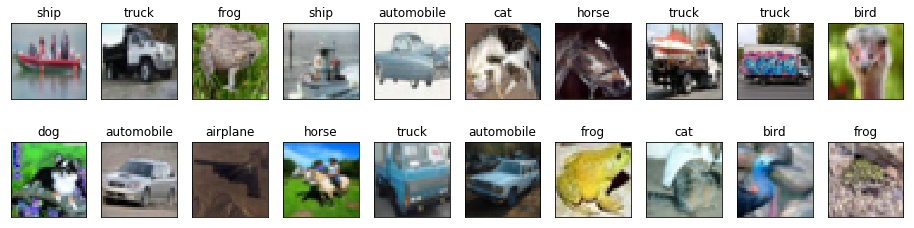

In [148]:
plt.figure(figsize = (16, 4))
for idx in range(len(images)):
    ax = plt.subplot(2, 10, idx+1, xticks = [], yticks = [])
    imshow(images[idx])
    ax.set_title(classes[labels[idx].item()])